In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
from simulators.cosmic_shear_nuisances.cosmic_shear import *
import ndes.nde as nde
import distributions.priors as priors
%matplotlib inline

Using Theano backend.


In [2]:
### SET UP FOR SIMULATION CODE ###

# n(z)
nz = 10
pz = np.loadtxt('simulators/cosmic_shear/pz.dat')
z = pz[0,:]
pz_fid = [0]*nz
for i in range(1, nz+1):
    pz_fid[i-1] = interpolate.InterpolatedUnivariateSpline(z, pz[i,:])
PZ = [0]*nz
for i in range(nz):
    z = np.concatenate([np.linspace(-0.5, 0, 100), pz_fid[i].get_knots()[1:]])
    p = np.concatenate([np.zeros(100), pz_fid[i](pz_fid[i].get_knots()[1:])])
    PZ[i] = interpolate.InterpolatedUnivariateSpline(z, p, k = 3)
pz_fid = PZ

# Set up fiducial parameters and binning
theta_fiducial = np.array([0.3, 0.8, 0.05, 0.70, 0.96, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
npar = 15

# Define the priors
lower = np.zeros(npar)
upper = np.zeros(npar)
lower[0:5] = np.array([0, 0.4, 0, 0.4, 0.7])
lower[5:] = np.ones(nz)*-0.1
upper[0:5] = np.array([1, 1.2, 0.1, 1.0, 1.3])
upper[5:] = np.ones(nz)*0.1
prior_mean = theta_fiducial
sigmas = np.zeros(npar)
sigmas[0:5] = np.array([0.1, 0.1, 0.05, 0.3, 0.3])
sigmas[5:] = np.ones(nz)*0.05
S = np.eye(npar)*sigmas**2
Sinv = np.linalg.inv(S)
prior_args = [prior_mean, S, lower, upper]

# Scale binning
lmax = 3000
lmin = 10
modes_edges = np.logspace(np.log10(lmin), np.log10(lmax), 11)
modes = (modes_edges[0:-1] + modes_edges[1:])/2
l = np.arange(lmin, lmax)
nl = np.array([sum((2*l[(l >= modes_edges[i])*(l < modes_edges[i+1])] + 1)) for i in range(len(modes))], dtype=int)

# Number of effective modes
A_sky = 15000*(np.pi/180)**2
f_sky = A_sky/(4*np.pi)
nl = np.array(nl*f_sky, dtype=int)

# Noise covariance
sigma_e = 0.3
nbar = 3*(60*180./np.pi)**2
N = (sigma_e**2/nbar)*np.eye(nz)

# Simulation arguments
sim_args = [pz_fid, modes, N, nl]

# Fiducial power spectrum
C = power_spectrum(theta_fiducial, sim_args)
Cinv = np.array([np.linalg.inv(C[:,:,l]) for l in range(len(modes))]).T

# Derivative of power spectrum
h = np.concatenate([abs(theta_fiducial[0:5])*np.array([0.05, 0.05, 0.1, 0.1, 0.05]), np.array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01])])
dCdt = np.zeros((npar, nz, nz, len(modes)))
# Derivatives wrt cosmological parameters
for i in range(npar-nz):
    theta_plus = np.copy(theta_fiducial)
    theta_plus[i] += h[i]
    theta_minus = np.copy(theta_fiducial)
    theta_minus[i] -= h[i]
    
    Cp = power_spectrum(theta_plus, [pz_fid, modes, np.zeros((nz, nz))])
    Cm = power_spectrum(theta_minus, [pz_fid, modes, np.zeros((nz, nz))])
    C0 = power_spectrum(theta_fiducial, [pz_fid, modes, np.zeros((nz, nz))])

    dCdt[i, :, :, :] = (Cp - Cm)/(2*h[i])
    
# Derivatives wrt photo-z bias parameters
for i in range(nz):
    
    pzprime = [interpolate.InterpolatedUnivariateSpline(np.linspace(0, pz_fid[0].get_knots()[-1], len(pz_fid[0].get_knots())), np.zeros(len(pz_fid[0].get_knots()))) for X in range(nz)]
    pzprime[i] = pz_fid[i].derivative()
    dCdt[npar-nz+i, :, :, :] = d_power_spectrum_db(theta_fiducial, [pz_fid, modes, np.zeros((nz, nz)), pzprime])

# Fisher matrix
F, Finv, fisher_errors = fisher_matrix(Cinv, dCdt, npar, nl, Sinv)

# Projection arguments
projection_args = [Finv, 0, theta_fiducial, fisher_errors, prior_mean, Sinv, Cinv, dCdt, modes, nl]

# SimABC args
simulator_args = [sim_args, projection_args, prior_args]

# Parameter names and ranges for plotting  
names = ['\Omega_m', 'S_8', '\Omega_b', 'h', 'n_s', 'b_1', 'b_2', 'b_3', 'b_4', 'b_5'
            , 'b_6', 'b_7', 'b_8', 'b_9', 'b_{10}']
labels =  ['\\Omega_m', 'S_8', '\\Omega_b', 'h', 'n_s', 'b_1', 'b_2', 'b_3', 'b_4', 'b_5'
            , 'b_6', 'b_7', 'b_8', 'b_9', 'b_{10}']
ranges = {'\Omega_m':[lower[0], upper[0]], 'S_8':[lower[1],upper[1]],'\Omega_b':[lower[2],upper[2]],
             'h':[lower[3],upper[3]],'n_s':[lower[4],upper[4]], 'b_1':[lower[5],upper[5]], 'b_2':[lower[6],upper[6]], 
              'b_3':[lower[7],upper[7]], 'b_4':[lower[8],upper[8]], 'b_5':[lower[9],upper[9]],
              'b_6':[lower[10],upper[10]], 'b_7':[lower[11],upper[11]], 'b_8':[lower[12],upper[12]],
              'b_9':[lower[13],upper[13]], 'b_{10}':[lower[14],upper[14]]}

In [3]:
# Define the simulator function: takes parameters, spits out simulated (compressed) summaries
def simulator(x, *args):
    
    return simulationABC(x, args[0])

In [4]:
# The data vector: import or otherwise simulate for testing
data = projected_score(power_spectrum(theta_fiducial, sim_args), projection_args)

In [5]:
# Create prior over parameters
prior = priors.TruncatedGaussian(prior_mean, S, lower, upper)

# Create asymptotic posterior approximation
asymptotic_posterior = priors.TruncatedGaussian(theta_fiducial, Finv, lower, upper)

In [6]:
# Create the DELFI MDN object
n_components = 3

mdn = nde.DelfiMixtureDensityNetwork(simulator, prior, asymptotic_posterior, Finv, theta_fiducial, data, n_components, simulator_args = simulator_args, n_hidden = [50, 50], activations = ['tanh', 'tanh'], names = names, labels = labels, ranges = ranges)

Generating pre-training data...
Training on the pre-training data...
Train on 90000 samples, validate on 10000 samples
Epoch 1/100
90000/90000 [==============================] - 158s 2ms/step - loss: 89.3348 - val_loss: 49.5108
Epoch 2/100
90000/90000 [==============================] - 160s 2ms/step - loss: 44.4588 - val_loss: 39.1729
Epoch 3/100
90000/90000 [==============================] - 159s 2ms/step - loss: 32.0373 - val_loss: 26.4570
Epoch 4/100
90000/90000 [==============================] - 158s 2ms/step - loss: 24.6709 - val_loss: 23.3352
Epoch 5/100
90000/90000 [==============================] - 150s 2ms/step - loss: 22.6924 - val_loss: 22.2016
Epoch 6/100
90000/90000 [==============================] - 157s 2ms/step - loss: 21.8523 - val_loss: 22.0335
Epoch 7/100
90000/90000 [==============================] - 152s 2ms/step - loss: 21.4276 - val_loss: 21.0120
Epoch 8/100
90000/90000 [==============================] - 150s 2ms/step - loss: 21.0762 - val_loss: 21.3498
Epoch 9/1

90000/90000 [==============================] - 148s 2ms/step - loss: 17.8340 - val_loss: 17.8294
Epoch 75/100
90000/90000 [==============================] - 160s 2ms/step - loss: 17.8634 - val_loss: 17.9464
Epoch 76/100
90000/90000 [==============================] - 157s 2ms/step - loss: 17.7850 - val_loss: 17.8061
Epoch 77/100
90000/90000 [==============================] - 143s 2ms/step - loss: 17.7930 - val_loss: 17.7051
Epoch 78/100
90000/90000 [==============================] - 154s 2ms/step - loss: 17.7518 - val_loss: 18.0147
Epoch 79/100
90000/90000 [==============================] - 163s 2ms/step - loss: 17.6956 - val_loss: 18.0246
Epoch 80/100
90000/90000 [==============================] - 157s 2ms/step - loss: 17.6624 - val_loss: 17.9944
Epoch 81/100
90000/90000 [==============================] - 154s 2ms/step - loss: 17.6708 - val_loss: 17.7693
Epoch 82/100
90000/90000 [==============================] - 141s 2ms/step - loss: 17.5876 - val_loss: 17.6399
Epoch 83/100
90000/9000

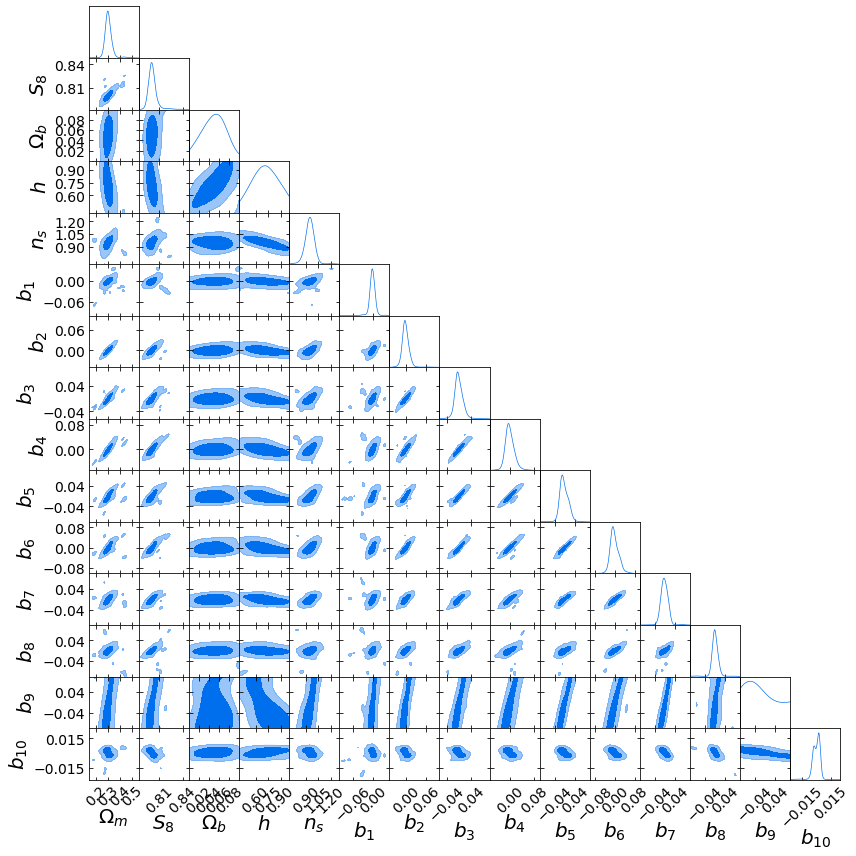

In [7]:
# Do the Fisher pre-training
mdn.fisher_pretraining(100000, prior, epochs=100)

Running initial 2000 sims...
Done.
Train on 1800 samples, validate on 200 samples
Epoch 1/100
1800/1800 [==============================] - 4s 2ms/step - loss: 19.9621 - val_loss: 17.8961
Epoch 2/100
1800/1800 [==============================] - 4s 2ms/step - loss: 17.8271 - val_loss: 17.0165
Epoch 3/100
1800/1800 [==============================] - 4s 2ms/step - loss: 16.8385 - val_loss: 16.5861
Epoch 4/100
1800/1800 [==============================] - 4s 2ms/step - loss: 16.4053 - val_loss: 16.2052
Epoch 5/100
1800/1800 [==============================] - 4s 2ms/step - loss: 15.9748 - val_loss: 15.8718
Epoch 6/100
1800/1800 [==============================] - 4s 2ms/step - loss: 15.6513 - val_loss: 15.7443
Epoch 7/100
1800/1800 [==============================] - 4s 2ms/step - loss: 15.4128 - val_loss: 15.5461
Epoch 8/100
1800/1800 [==============================] - 4s 2ms/step - loss: 15.1674 - val_loss: 15.3030
Epoch 9/100
1800/1800 [==============================] - 4s 2ms/step - loss: 1

1800/1800 [==============================] - 4s 2ms/step - loss: 12.8752 - val_loss: 13.8210
Epoch 78/100
1800/1800 [==============================] - 4s 2ms/step - loss: 12.8533 - val_loss: 13.9381
Epoch 79/100
1800/1800 [==============================] - 4s 2ms/step - loss: 12.8954 - val_loss: 13.9299
Epoch 80/100
1800/1800 [==============================] - 4s 2ms/step - loss: 12.9742 - val_loss: 14.0268
Epoch 81/100
1800/1800 [==============================] - 4s 2ms/step - loss: 12.9159 - val_loss: 13.8809
Epoch 82/100
1800/1800 [==============================] - 4s 2ms/step - loss: 12.8201 - val_loss: 13.8822
Epoch 83/100
1800/1800 [==============================] - 4s 2ms/step - loss: 12.8307 - val_loss: 13.9129
Epoch 84/100
1800/1800 [==============================] - 4s 2ms/step - loss: 12.8991 - val_loss: 13.9726
Epoch 85/100
1800/1800 [==============================] - 4s 2ms/step - loss: 12.8845 - val_loss: 14.0253
Epoch 86/100
1800/1800 [==============================] - 4

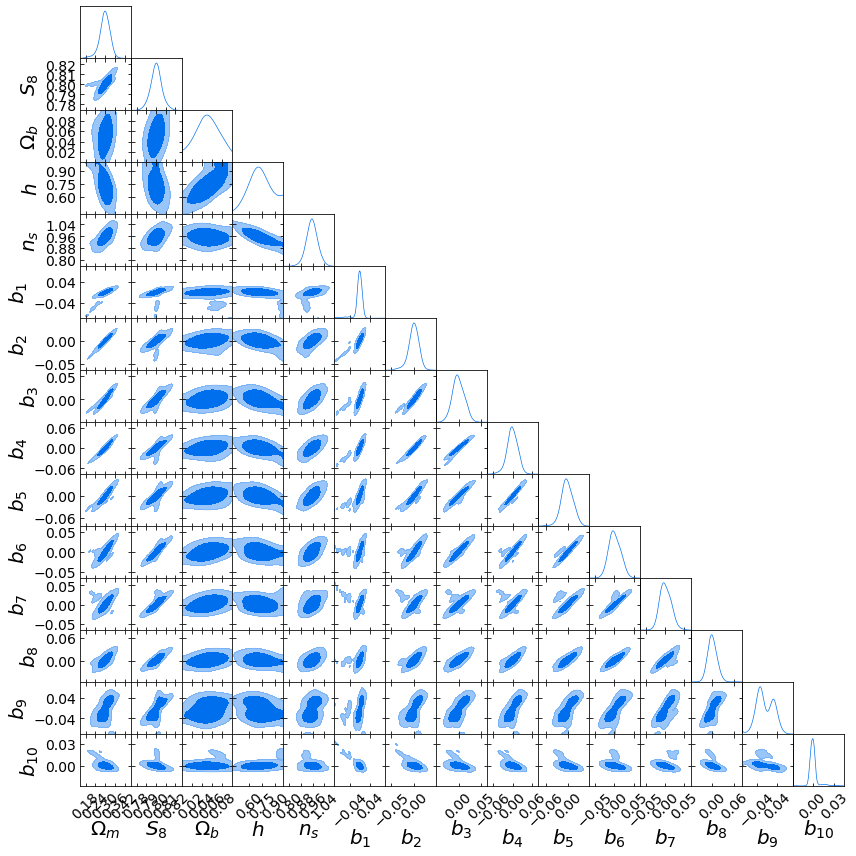

Population 1/14
Sampling proposal density...
Done.
Running 2000 sims...
Simulator return exception with parameter values: [ 0.15233879  0.79378807  0.04696595  0.67857226  1.09090607 -0.05939479
 -0.06708907 -0.09051757 -0.05741895 -0.05014907 -0.0664151  -0.02576362
 -0.04744657 -0.09881339  0.0023059 ]
Simulator return exception with parameter values: [ 0.15233879  0.79378807  0.04696595  0.67857226  1.09090607 -0.05939479
 -0.06708907 -0.09051757 -0.05741895 -0.05014907 -0.0664151  -0.02576362
 -0.04744657 -0.09881339  0.0023059 ]
Simulator return exception with parameter values: [ 0.15829721  0.79360497  0.0456493   0.67395391  1.08255409 -0.05097728
 -0.06422565 -0.08461203 -0.05623739 -0.04744102 -0.06672176 -0.02849403
 -0.04655183 -0.09028701  0.00272013]
Simulator return exception with parameter values: [ 0.14914054  0.7931353   0.0476136   0.66595021  1.09676275 -0.05507572
 -0.06877642 -0.0910567  -0.06014328 -0.05004803 -0.07280176 -0.0291678
 -0.0481905  -0.09311395  0.003

3600/3600 [==============================] - 10s 3ms/step - loss: 13.2591 - val_loss: 33.6829
Epoch 12/100
3600/3600 [==============================] - 10s 3ms/step - loss: 13.2023 - val_loss: 33.3449
Epoch 13/100
3600/3600 [==============================] - 10s 3ms/step - loss: 13.1675 - val_loss: 33.3621
Epoch 14/100
3600/3600 [==============================] - 10s 3ms/step - loss: 13.1717 - val_loss: 33.4498
Epoch 15/100
3600/3600 [==============================] - 10s 3ms/step - loss: 13.1135 - val_loss: 33.6655
Epoch 16/100
3600/3600 [==============================] - 10s 3ms/step - loss: 13.1311 - val_loss: 33.5448
Epoch 17/100
3600/3600 [==============================] - 11s 3ms/step - loss: 13.2011 - val_loss: 33.4120
Epoch 18/100
3600/3600 [==============================] - 10s 3ms/step - loss: 13.1390 - val_loss: 33.3896
Epoch 19/100
3600/3600 [==============================] - 10s 3ms/step - loss: 13.0889 - val_loss: 33.7083
Epoch 20/100
3600/3600 [==========================

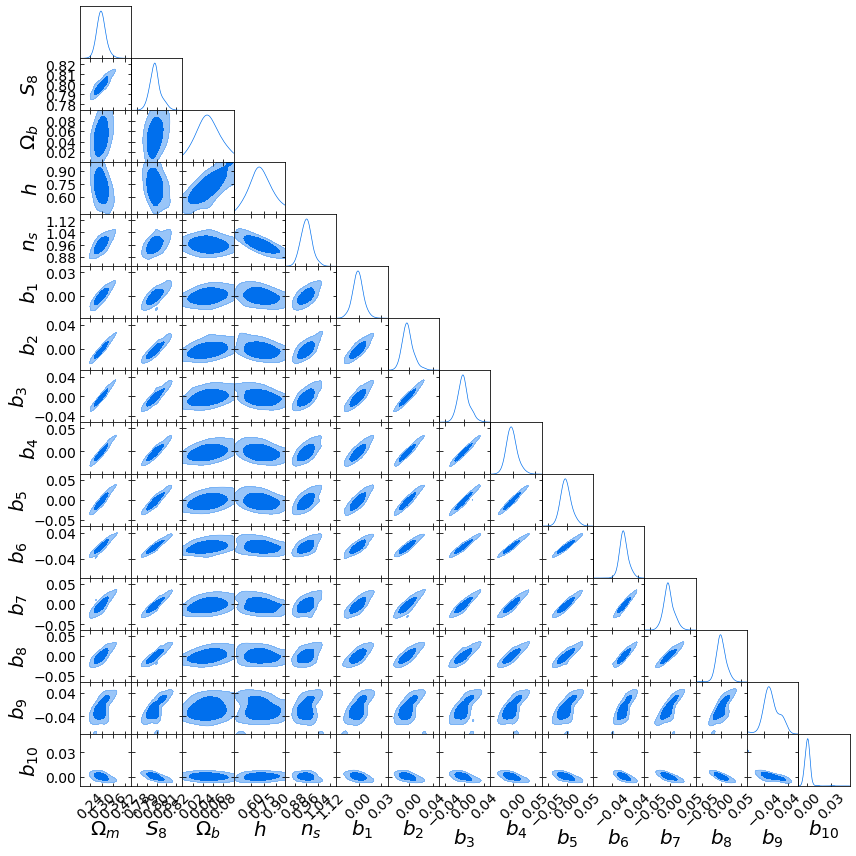

Population 2/14
Sampling proposal density...
Done.
Running 2000 sims...
Done.
Train on 5400 samples, validate on 600 samples
Epoch 1/100
5400/5400 [==============================] - 17s 3ms/step - loss: 16.9242 - val_loss: 18.6066
Epoch 2/100
5400/5400 [==============================] - 14s 3ms/step - loss: 15.5518 - val_loss: 17.5473
Epoch 3/100
5400/5400 [==============================] - 15s 3ms/step - loss: 14.9691 - val_loss: 17.1931
Epoch 4/100
5400/5400 [==============================] - 15s 3ms/step - loss: 14.5309 - val_loss: 16.6260
Epoch 5/100
5400/5400 [==============================] - 14s 3ms/step - loss: 14.2886 - val_loss: 16.7772
Epoch 6/100
5400/5400 [==============================] - 15s 3ms/step - loss: 14.1508 - val_loss: 16.6176
Epoch 7/100
5400/5400 [==============================] - 14s 3ms/step - loss: 13.9871 - val_loss: 16.6376
Epoch 8/100
5400/5400 [==============================] - 20s 4ms/step - loss: 13.9786 - val_loss: 16.5034
Epoch 9/100
5400/5400 [====

5400/5400 [==============================] - 15s 3ms/step - loss: 12.7590 - val_loss: 14.2960
Epoch 77/100
5400/5400 [==============================] - 15s 3ms/step - loss: 12.7191 - val_loss: 14.5489
Epoch 78/100
5400/5400 [==============================] - 15s 3ms/step - loss: 12.7370 - val_loss: 14.2289
Epoch 79/100
5400/5400 [==============================] - 15s 3ms/step - loss: 12.7403 - val_loss: 14.5833
Epoch 80/100
5400/5400 [==============================] - 15s 3ms/step - loss: 12.7437 - val_loss: 14.4560
Epoch 81/100
5400/5400 [==============================] - 15s 3ms/step - loss: 12.7488 - val_loss: 14.2809
Epoch 82/100
5400/5400 [==============================] - 22s 4ms/step - loss: 12.6969 - val_loss: 14.4343
Epoch 83/100
5400/5400 [==============================] - 15s 3ms/step - loss: 12.7308 - val_loss: 14.5554
Epoch 84/100
5400/5400 [==============================] - 14s 3ms/step - loss: 12.7493 - val_loss: 14.8569
Epoch 85/100
5400/5400 [==========================

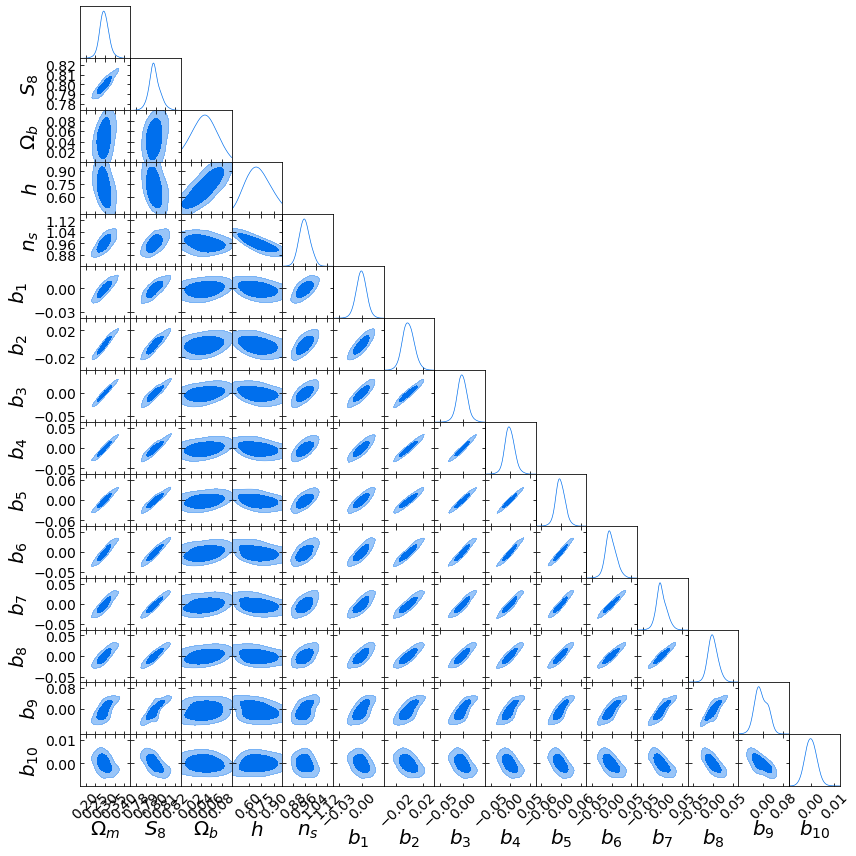

Population 3/14
Sampling proposal density...
Done.
Running 2000 sims...
Simulator return exception with parameter values: [ 0.14300774  0.79378918  0.04627862  0.81562342  0.97495835 -0.0323469
 -0.03167448 -0.09239346 -0.06830148 -0.02685988 -0.073844   -0.04708583
 -0.04991946 -0.05249375  0.00863607]
Simulator return exception with parameter values: [ 0.15124599  0.7941347   0.05047287  0.80235824  0.98901723 -0.03128782
 -0.02839419 -0.08418491 -0.06165715 -0.02211699 -0.06969105 -0.04319964
 -0.04178647 -0.03790986  0.00809678]
Simulator return exception with parameter values: [ 0.15185531  0.7940662   0.05148576  0.81468498  0.98780019 -0.03246845
 -0.02838898 -0.08489921 -0.06225252 -0.02225438 -0.07019901 -0.04366179
 -0.04324366 -0.03641146  0.0107682 ]
Simulator return exception with parameter values: [ 0.15185531  0.7940662   0.05148576  0.81468498  0.98780019 -0.03246845
 -0.02838898 -0.08489921 -0.06225252 -0.02225438 -0.07019901 -0.04366179
 -0.04324366 -0.03641146  0.010

Simulator return exception with parameter values: [ 0.18709207  0.79677357  0.05894968  0.57486434  1.04822249 -0.04377078
 -0.05300616 -0.03758729 -0.02823828 -0.01943595 -0.02777608 -0.02660183
  0.0849638   0.06342436  0.00640731]
Simulator return exception with parameter values: [ 0.18467326  0.79522498  0.04636395  0.5192556   1.04871479 -0.04002313
 -0.05135541 -0.04307535 -0.03463629 -0.02354185 -0.03293009 -0.04293188
  0.06451364  0.06277142  0.00347979]
Simulator return exception with parameter values: [ 0.18467326  0.79522498  0.04636395  0.5192556   1.04871479 -0.04002313
 -0.05135541 -0.04307535 -0.03463629 -0.02354185 -0.03293009 -0.04293188
  0.06451364  0.06277142  0.00347979]
Simulator return exception with parameter values: [ 0.18467326  0.79522498  0.04636395  0.5192556   1.04871479 -0.04002313
 -0.05135541 -0.04307535 -0.03463629 -0.02354185 -0.03293009 -0.04293188
  0.06451364  0.06277142  0.00347979]
Simulator return exception with parameter values: [ 0.12457854  

Simulator return exception with parameter values: [ 0.13813801  0.79371708  0.08232833  0.6675562   1.07786431 -0.03011992
 -0.05331302 -0.08261372 -0.05681633 -0.02449984 -0.07470398 -0.03882623
  0.00913007  0.01514427 -0.00364236]
Simulator return exception with parameter values: [ 0.13813801  0.79371708  0.08232833  0.6675562   1.07786431 -0.03011992
 -0.05331302 -0.08261372 -0.05681633 -0.02449984 -0.07470398 -0.03882623
  0.00913007  0.01514427 -0.00364236]
Simulator return exception with parameter values: [ 0.14029352  0.79378603  0.08151249  0.6666393   1.07709474 -0.02958076
 -0.05194239 -0.081485   -0.05597564 -0.02385167 -0.07375312 -0.0386491
  0.00826939  0.0150753  -0.00372469]
Simulator return exception with parameter values: [ 0.14029352  0.79378603  0.08151249  0.6666393   1.07709474 -0.02958076
 -0.05194239 -0.081485   -0.05597564 -0.02385167 -0.07375312 -0.0386491
  0.00826939  0.0150753  -0.00372469]
Simulator return exception with parameter values: [ 0.1403667   0.

Simulator return exception with parameter values: [ 0.14909323  0.79550231  0.09745234  0.68668356  1.08788345 -0.05708664
 -0.09747774 -0.09396477 -0.06518447 -0.04448588 -0.09111889  0.01059964
  0.05119002 -0.01372816  0.02835878]
Simulator return exception with parameter values: [ 0.14909323  0.79550231  0.09745234  0.68668356  1.08788345 -0.05708664
 -0.09747774 -0.09396477 -0.06518447 -0.04448588 -0.09111889  0.01059964
  0.05119002 -0.01372816  0.02835878]
Simulator return exception with parameter values: [ 0.14909323  0.79550231  0.09745234  0.68668356  1.08788345 -0.05708664
 -0.09747774 -0.09396477 -0.06518447 -0.04448588 -0.09111889  0.01059964
  0.05119002 -0.01372816  0.02835878]
Simulator return exception with parameter values: [ 0.14909323  0.79550231  0.09745234  0.68668356  1.08788345 -0.05708664
 -0.09747774 -0.09396477 -0.06518447 -0.04448588 -0.09111889  0.01059964
  0.05119002 -0.01372816  0.02835878]
Simulator return exception with parameter values: [ 0.14909323  

Simulator return exception with parameter values: [ 0.16612691  0.79501913  0.09953368  0.63800533  1.12290651 -0.05323293
 -0.09010071 -0.08777939 -0.05876267 -0.03903952 -0.09317552  0.01539792
  0.04275096 -0.00578491  0.02818712]
Simulator return exception with parameter values: [ 0.16693777  0.79501064  0.09953615  0.63611666  1.12410331 -0.05300234
 -0.08961277 -0.08731245 -0.05836082 -0.03871203 -0.09303073  0.01551464
  0.04252259 -0.00521534  0.02809986]
Simulator return exception with parameter values: [ 0.16693777  0.79501064  0.09953615  0.63611666  1.12410331 -0.05300234
 -0.08961277 -0.08731245 -0.05836082 -0.03871203 -0.09303073  0.01551464
  0.04252259 -0.00521534  0.02809986]
Simulator return exception with parameter values: [ 0.16693777  0.79501064  0.09953615  0.63611666  1.12410331 -0.05300234
 -0.08961277 -0.08731245 -0.05836082 -0.03871203 -0.09303073  0.01551464
  0.04252259 -0.00521534  0.02809986]
Simulator return exception with parameter values: [ 0.16693777  

Simulator return exception with parameter values: [ 1.69199799e-01  7.93834112e-01  9.42942368e-02  6.19845225e-01
  1.13460715e+00 -4.70698989e-02 -7.37449612e-02 -8.16719667e-02
 -5.51861297e-02 -3.03925660e-02 -9.22847984e-02 -3.00132161e-05
  2.22957833e-02  1.44273267e-02  2.38312905e-02]
Simulator return exception with parameter values: [ 1.69199799e-01  7.93834112e-01  9.42942368e-02  6.19845225e-01
  1.13460715e+00 -4.70698989e-02 -7.37449612e-02 -8.16719667e-02
 -5.51861297e-02 -3.03925660e-02 -9.22847984e-02 -3.00132161e-05
  2.22957833e-02  1.44273267e-02  2.38312905e-02]
Simulator return exception with parameter values: [ 1.69199799e-01  7.93834112e-01  9.42942368e-02  6.19845225e-01
  1.13460715e+00 -4.70698989e-02 -7.37449612e-02 -8.16719667e-02
 -5.51861297e-02 -3.03925660e-02 -9.22847984e-02 -3.00132161e-05
  2.22957833e-02  1.44273267e-02  2.38312905e-02]
Simulator return exception with parameter values: [ 1.69199799e-01  7.93834112e-01  9.42942368e-02  6.19845225e-01


7200/7200 [==============================] - 22s 3ms/step - loss: 12.5864 - val_loss: 27.0927
Epoch 53/100
7200/7200 [==============================] - 22s 3ms/step - loss: 12.5924 - val_loss: 27.2692
Epoch 54/100
7200/7200 [==============================] - 22s 3ms/step - loss: 12.5574 - val_loss: 27.2836
Epoch 55/100
7200/7200 [==============================] - 22s 3ms/step - loss: 12.5109 - val_loss: 26.7889
Epoch 56/100
7200/7200 [==============================] - 22s 3ms/step - loss: 12.5664 - val_loss: 27.1236
Epoch 57/100
7200/7200 [==============================] - 22s 3ms/step - loss: 12.4616 - val_loss: 27.2494
Epoch 58/100
7200/7200 [==============================] - 22s 3ms/step - loss: 12.4949 - val_loss: 27.0689
Epoch 59/100
7200/7200 [==============================] - 22s 3ms/step - loss: 12.4709 - val_loss: 27.1070
Epoch 60/100
7200/7200 [==============================] - 22s 3ms/step - loss: 12.5025 - val_loss: 27.2833
Epoch 61/100
7200/7200 [==========================

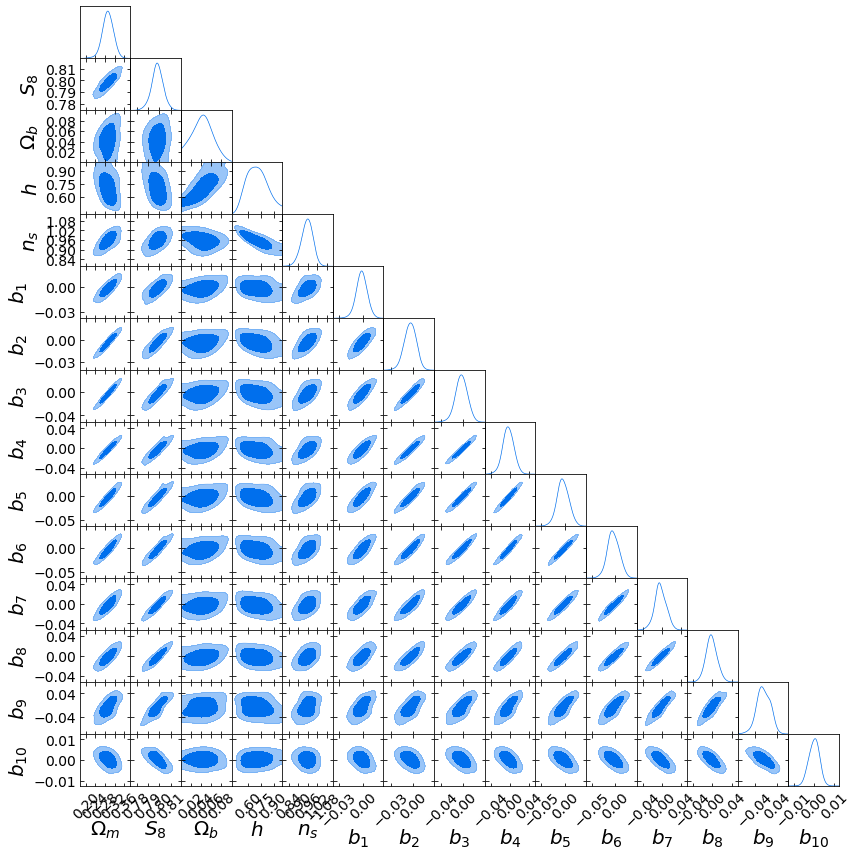

Population 4/14
Sampling proposal density...
Done.
Running 2000 sims...
Done.
Train on 9000 samples, validate on 1000 samples
Epoch 1/100
9000/9000 [==============================] - 32s 4ms/step - loss: 14.0822 - val_loss: 14.2852
Epoch 2/100
9000/9000 [==============================] - 32s 4ms/step - loss: 13.7848 - val_loss: 14.6878
Epoch 3/100
9000/9000 [==============================] - 32s 4ms/step - loss: 13.6203 - val_loss: 14.6672
Epoch 4/100
9000/9000 [==============================] - 32s 4ms/step - loss: 13.2456 - val_loss: 13.9314
Epoch 5/100
9000/9000 [==============================] - 32s 4ms/step - loss: 13.0642 - val_loss: 14.6120
Epoch 6/100
9000/9000 [==============================] - 32s 4ms/step - loss: 13.1181 - val_loss: 13.7901
Epoch 7/100
9000/9000 [==============================] - 32s 4ms/step - loss: 12.9990 - val_loss: 15.0501
Epoch 8/100
9000/9000 [==============================] - 32s 4ms/step - loss: 12.9718 - val_loss: 13.6077
Epoch 9/100
9000/9000 [===

9000/9000 [==============================] - 31s 3ms/step - loss: 12.0645 - val_loss: 12.1620
Epoch 77/100
9000/9000 [==============================] - 31s 3ms/step - loss: 12.1358 - val_loss: 12.4215
Epoch 78/100
9000/9000 [==============================] - 31s 3ms/step - loss: 12.1230 - val_loss: 11.9413
Epoch 79/100
9000/9000 [==============================] - 31s 3ms/step - loss: 12.0610 - val_loss: 12.3474
Epoch 80/100
9000/9000 [==============================] - 31s 3ms/step - loss: 12.1145 - val_loss: 12.0628
Epoch 81/100
9000/9000 [==============================] - 32s 4ms/step - loss: 12.1199 - val_loss: 11.7273
Epoch 82/100
9000/9000 [==============================] - 32s 4ms/step - loss: 12.0635 - val_loss: 11.9134
Epoch 83/100
9000/9000 [==============================] - 31s 3ms/step - loss: 12.0412 - val_loss: 11.9721
Epoch 84/100
9000/9000 [==============================] - 32s 4ms/step - loss: 12.0390 - val_loss: 11.9128
Epoch 85/100
9000/9000 [==========================

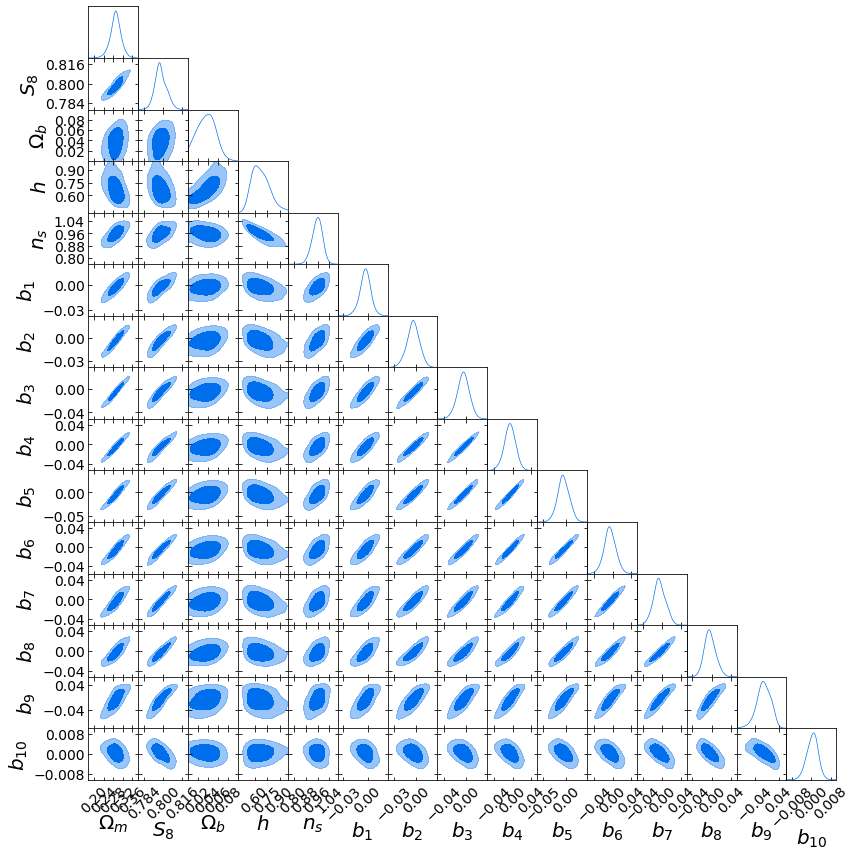

Population 5/14
Sampling proposal density...
Done.
Running 2000 sims...
Done.
Train on 10800 samples, validate on 1200 samples
Epoch 1/100
10800/10800 [==============================] - 42s 4ms/step - loss: 12.4234 - val_loss: 16.0194
Epoch 2/100
10800/10800 [==============================] - 42s 4ms/step - loss: 12.2102 - val_loss: 15.5994
Epoch 3/100
10800/10800 [==============================] - 42s 4ms/step - loss: 12.1946 - val_loss: 15.4784
Epoch 4/100
10800/10800 [==============================] - 42s 4ms/step - loss: 12.1399 - val_loss: 15.4971
Epoch 5/100
10800/10800 [==============================] - 42s 4ms/step - loss: 12.1556 - val_loss: 15.9907
Epoch 6/100
10800/10800 [==============================] - 42s 4ms/step - loss: 12.0769 - val_loss: 15.1885
Epoch 7/100
10800/10800 [==============================] - 42s 4ms/step - loss: 12.0097 - val_loss: 15.2057
Epoch 8/100
10800/10800 [==============================] - 42s 4ms/step - loss: 12.0338 - val_loss: 15.1404
Epoch 9/1

Done.


DensitiesError: Contour level outside plotted ranges

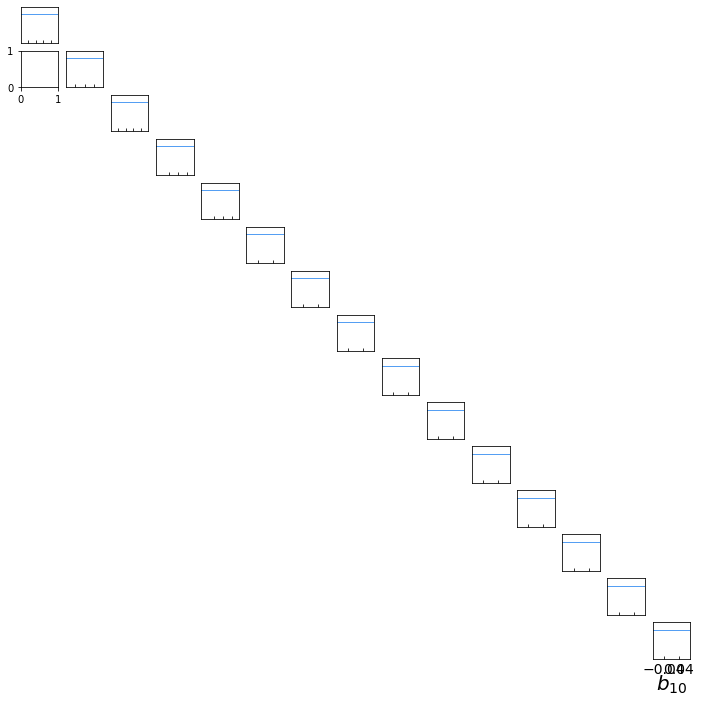

In [8]:
# Proposal for the SNL
proposal = priors.TruncatedGaussian(theta_fiducial, 9*Finv, lower, upper)

# Initial samples, batch size for population samples, number of populations
n_initial = 2000
n_batch = 2000
n_populations = 14

# Do the SNL training
mdn.sequential_training(n_initial, n_batch, n_populations, proposal)

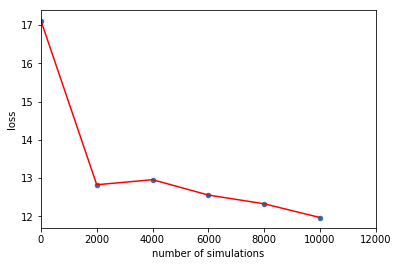

In [9]:
plt.scatter(mdn.n_sim_trace, mdn.loss_trace, s = 20)
plt.plot(mdn.n_sim_trace, mdn.loss_trace, color = 'red')
plt.xlim(0, mdn.n_sim_trace[-1])
plt.xlabel('number of simulations')
plt.ylabel('loss')
plt.show()